In [1]:
from google.colab import drive
drive.mount('/content/drive/')         

Mounted at /content/drive/


In [2]:
import os
os.getcwd()
p=%cd /content/drive/My Drive/bigdata2            
p

/content/drive/My Drive/bigdata2


In [3]:
import pandas as pd
df =  pd.read_csv('audiology.csv', sep=",")

In [4]:
from keras.models import Model,Sequential                                                                                          
from tensorflow.keras import optimizers                                                      
from keras.layers import Input,Conv1D,BatchNormalization,MaxPooling1D,LSTM,Dense,Activation,Layer
from tensorflow.keras.utils import to_categorical

import keras.backend as K
import argparse
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [5]:

X = df.iloc[:, 0:69]
y = df.iloc[:, 69]

from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
X = ord_enc.fit_transform(X)

onehotencoder = OneHotEncoder()
y=y.values.reshape(-1,1)

y= onehotencoder.fit_transform(y).toarray()
X = np.array(X)


In [6]:

from sklearn.model_selection import train_test_split
x_tr, x_t, y_tr, y_t = train_test_split( X, y, test_size=0.33, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr,y_tr,test_size = 0.25,train_size =0.75)


In [7]:
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [8]:
def loadData(x_tr,x_t,x_val,y_tr,y_t,y_val):
              
	x_tr = x_tr.reshape(-1,x_tr.shape[1],1)
	x_t = x_t.reshape(-1,x_t.shape[1],1)
	x_val = x_val.reshape(-1,x_val.shape[1],1)
	y_tr = y_tr
	y_t = y_t
	y_val = y_val
	return x_tr,y_tr,x_t,y_t,x_val,y_val
x_tr,y_tr,x_t,y_t,x_val,y_val = loadData(x_tr,x_t,x_val,y_tr,y_t,y_val)

In [9]:
parser = argparse.ArgumentParser()
args, _ = parser.parse_known_args()

args.num_fc = 64                                                                
args.batch_size = 4                                                             
args.num_epochs = 1000     
args.learning_rate = 0.0001                                                          
args.decay = 1e-6                                                                    
args.momentum = 0.9                                                                 
input_shape=x_tr.shape[1:]                                                             
num_classes=len(np.unique(np.argmax(y_tr, 1)))                                      

In [10]:
from keras.layers import Embedding
from keras.layers import Bidirectional


In [11]:
model = Sequential()
model.add(Conv1D(filters = 64,kernel_size = (3),strides=1,padding='same',data_format='channels_last',input_shape=input_shape))	
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size = 4, strides = 4))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Conv1D(filters=64, kernel_size = 3, strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size = 1, strides = 4))
model.add(attention(return_sequences=True)) # receive 3D and output 3D
model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size = 1, strides = 4))
model.add(attention(return_sequences=True)) # receive 3D and output 3D
model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size = 1, strides = 3))
model.add((LSTM(32)))

model.add(Dense(units=num_classes,activation='softmax'))
model.summary()
opt = optimizers.SGD(lr = args.learning_rate, decay=args.decay, momentum=args.momentum, nesterov=True)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['categorical_accuracy'])	


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 69, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 69, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 69, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 17, 64)           24832     
 l)                                                              
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history = model.fit(x_tr,y_tr,epochs=args.num_epochs,batch_size=args.batch_size,validation_data=(x_val,y_val))

Epoch 1/1000
29/29 [==============================] - 9s 72ms/step - loss: 0.6992 - categorical_accuracy: 0.4956 - val_loss: 0.6940 - val_categorical_accuracy: 0.3684
Epoch 2/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.6721 - categorical_accuracy: 0.6991 - val_loss: 0.6944 - val_categorical_accuracy: 0.3684
Epoch 3/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.6585 - categorical_accuracy: 0.7257 - val_loss: 0.6942 - val_categorical_accuracy: 0.3684
Epoch 4/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.6462 - categorical_accuracy: 0.7699 - val_loss: 0.6935 - val_categorical_accuracy: 0.3684
Epoch 5/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.6343 - categorical_accuracy: 0.7876 - val_loss: 0.6924 - val_categorical_accuracy: 0.6316
Epoch 6/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.6224 - categorical_accuracy: 0.7788 - val_loss: 0.6907 - val_categorical_accuracy: 0.631

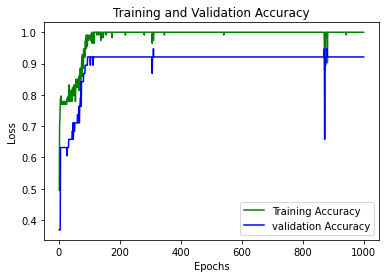

In [13]:
from matplotlib import pyplot as plt

loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

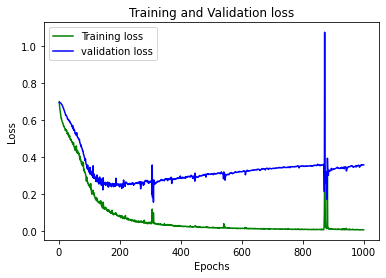

In [14]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
ypred = model.predict(x_t)
ypred1 = [np.round(x) for x in ypred]


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.utils import extmath
from sklearn.svm import SVC  
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
ypred = ypred1
y_test = y_t

ypred1=pd.DataFrame(ypred1)
n_classes = ypred1.shape[1]
ypred1 = np.array(ypred1)
# Plotting and estimation of FPR,TPR 
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ypred1[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  colors = cycle(['blue', 'green', 'red','darkorange','olive','purple','navy'])
for i, color in zip(range(n_classes), colors):
  pyplot.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0}(area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
  pyplot.plot([0, 1], [0, 1], 'k--', lw=1.5)
  pyplot.xlim([-0.05, 1.0])
  pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False Positive Rate',fontsize=12, fontweight='bold')
pyplot.ylabel('True Positive Rate',fontsize=12, fontweight='bold')
pyplot.tick_params(labelsize=12)
pyplot.legend(loc="lower right")
ax = pyplot.axes()
pyplot.show()
